In [1]:
#https://github.com/Curt-Park/rainbow-is-all-you-need/blob/master/01.dqn.ipynb

In [1]:
import gym
import highway_env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import Dict, Tuple, List
from pyvirtualdisplay import Display

In [2]:
class ReplayBuffer:
    
    def __init__(self, obs_dim, size, batch_size=32):
        # Assuming obs_dim is a tuple representing the shape of 2D observations
        self.obs_buf = np.zeros([size] + list(obs_dim), dtype=np.float32)
        self.next_obs_buf = np.zeros([size] + list(obs_dim), dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        print(f"New buffer size: {self.size}, New pointer position: {self.ptr}")
        
        print(f"Storing in buffer at position {self.ptr}")
        print(f"Observation: {obs}")
        print(f"Action: {act}")
        print(f"Reward: {rew}")
        print(f"Next Observation: {next_obs}")
        print(f"Done: {done}")

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [3]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        # Flatten the input dimension if it is multi-dimensional
        if isinstance(in_dim, tuple):
            in_dim = np.prod(in_dim)

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

In [4]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

        
    def __init__(self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
      ):
        # Assuming the observation space is 2D
        obs_dim = env.observation_space.shape
        action_dim = env.action_space.n

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state):
        """Select an action from the input state."""
        # epsilon greedy policy
        flat_state = state.flatten() if isinstance(state, np.ndarray) else state
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool]:
        """Take an action and return the response of the env."""
        # Dynamically capture all returned values from the step method
        step_results = self.env.step(action)

        # Extract next_state, reward, and done; ignore additional values
        next_state, reward, done = step_results[:3]

        # Check for additional information if necessary
        # If the environment returns an 'info' dictionary as the fourth value, you can extract it like this:
        # info = step_results[3] if len(step_results) > 3 else {}

        # Flatten next_state if necessary
        flat_next_state = next_state.flatten() if isinstance(next_state, np.ndarray) else next_state

        return flat_next_state, reward, done

    def update_model(self) -> torch.Tensor:
        # At the start of the update_model method
        print("update_model method is called")

        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)
        

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Inside the update_model method, after loss.backward() and optimizer.step()
        print(f"Loss after update {update_cnt}: {loss.item()}")

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        # At the start of the train method
        print("train method is called")
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0
                
            #print(f"Replay buffer size: {len(self.memory)}")

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # Inside the train method, after updating epsilon
                print(f"Epsilon after frame {frame_idx}: {self.epsilon}")
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True
        
        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        
        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(
            next_state
        ).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

In [5]:
import highway_env
import gymnasium as gym

In [6]:

# ReplayBuffer, Network, and DQNAgent classes as provided

# Initialize the Highway Environment
env = gym.make("highway-v0", max_episode_steps=200, render_mode="human")
env.configure({
    "observation": {
        "type": "Kinematics",
    },
    "action": {
        "type": "DiscreteMetaAction",
    }
})

# Define obs_dim and action_dim based on the environment
#obs_dim = env.observation_space.shape
#action_dim = env.action_space.n  # This is the line you need to add

# Seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# DQN Agent Parameters
num_frames = 400
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

# Initialize DQN Agent
agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)




C:\Users\shikh\AppData\Roaming\Python\Python38\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


cpu


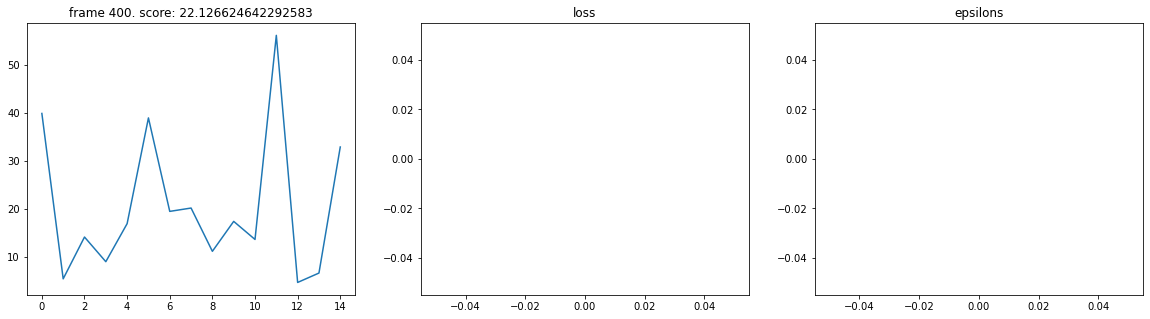

In [7]:
# Train the Agent
agent.train(num_frames)

